In [4]:
# Tweet Classifier using NLP
# This project classifies tweets as disaster-related or not

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import string
import pickle

In [6]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/siddheshbharapte/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddheshbharapte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# Phase 1: Data Acquisition
# For this implementation, we'll assume we have a Kaggle dataset with columns:
# id, text, target (1 for disaster, 0 for non-disaster)

def load_data(filepath='train.csv'):
    """Load the dataset from CSV file"""
    try:
        data = pd.read_csv(filepath)
        print(f"Dataset loaded with shape: {data.shape}")
        return data
    except FileNotFoundError:
        print("Please provide the correct path to the dataset")
        # For demonstration, create a small sample dataset
        sample_data = pd.DataFrame({
            'id': range(10),
            'text': [
                "Forest fire near the village, evacuations ordered",
                "The hurricane is approaching the coast",
                "Earthquake reported in the region",
                "Having a great time at the beach today",
                "Just finished my coffee, heading to work",
                "Flood warnings issued for riverside communities",
                "New music album released today, so excited",
                "Tornado has destroyed several homes",
                "Traffic is terrible this morning",
                "Tsunami alert after the earthquake"
            ],
            'target': [1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
        })
        print("Using sample dataset for demonstration")
        return sample_data

In [12]:
# Phase 2: Data Preprocessing & Feature Engineering

def clean_text(text):
    """Clean and preprocess text data"""
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        
        # Remove user mentions (@username)
        text = re.sub(r'@\w+', '', text)
        
        # Remove hashtags (#topic) - keep the text without #
        text = re.sub(r'#(\w+)', r'\1', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    return ""

def preprocess_data(df):
    """Apply preprocessing to the dataset"""
    # Create a copy to avoid modifying the original
    processed_df = df.copy()
    
    # Clean text
    processed_df['cleaned_text'] = processed_df['text'].apply(clean_text)
    
    # Tokenize
    processed_df['tokens'] = processed_df['cleaned_text'].apply(word_tokenize)
    
    # Remove stopwords and apply stemming
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    
    def remove_stopwords_and_stem(tokens):
        return [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    processed_df['processed_tokens'] = processed_df['tokens'].apply(remove_stopwords_and_stem)
    
    # Join tokens back into a string for TF-IDF
    processed_df['processed_text'] = processed_df['processed_tokens'].apply(lambda x: ' '.join(x))
    
    return processed_df

def extract_features(train_texts, test_texts):
    """Convert text to TF-IDF features"""
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    
    return X_train, X_test, vectorizer

In [14]:
# Phase 3: Model Development & Training

def train_models(X_train, y_train):
    """Train multiple models and return the best one"""
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42)
    }
    
    best_model = None
    best_score = 0
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        score = model.score(X_train, y_train)
        results[name] = {'model': model, 'score': score}
        
        if score > best_score:
            best_score = score
            best_model = {'name': name, 'model': model}
    
    print(f"Best model: {best_model['name']} with score: {best_score}")
    return results, best_model

def tune_hyperparameters(X_train, y_train, best_model_name):
    """Tune hyperparameters for the best model"""
    param_grids = {
        'Logistic Regression': {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'saga']
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        },
        'SVM': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    }
    
    if best_model_name == 'Logistic Regression':
        model = LogisticRegression(random_state=42, max_iter=1000)
    elif best_model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
    else:  # SVM
        model = SVC(probability=True, random_state=42)
    
    grid_search = GridSearchCV(
        model, 
        param_grids[best_model_name], 
        cv=5, 
        scoring='f1',
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_}")
    
    return grid_search.best_estimator_

In [25]:

# Phase 4: Evaluation & Validation

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance"""
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Disaster', 'Disaster'],
                yticklabels=['Non-Disaster', 'Disaster'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Disaster', 'Disaster']))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }


In [18]:
# Phase 5: Deployment

def save_model(model, vectorizer, output_path='disaster_tweet_model.pkl'):
    """Save the model and vectorizer for deployment"""
    model_data = {
        'model': model,
        'vectorizer': vectorizer
    }
    
    with open(output_path, 'wb') as file:
        pickle.dump(model_data, file)
    
    print(f"Model saved to {output_path}")

def predict_tweet(tweet_text, model_path='disaster_tweet_model.pkl'):
    """Make prediction on new tweet text"""
    # Load the model and vectorizer
    with open(model_path, 'rb') as file:
        model_data = pickle.load(file)
    
    model = model_data['model']
    vectorizer = model_data['vectorizer']
    
    # Preprocess the tweet
    cleaned_tweet = clean_text(tweet_text)
    
    # Convert to features
    tweet_features = vectorizer.transform([cleaned_tweet])
    
    # Make prediction
    prediction = model.predict(tweet_features)[0]
    probability = model.predict_proba(tweet_features)[0][1]
    
    result = "Disaster" if prediction == 1 else "Non-Disaster"
    
    return {
        'text': tweet_text,
        'prediction': result,
        'probability': probability,
        'label': int(prediction)
    }


Starting Tweet Classifier Project...
Please provide the correct path to the dataset
Using sample dataset for demonstration

Class Distribution:
target
1    6
0    4
Name: count, dtype: int64

Preprocessing data...

Extracting features...

Training models...
Training Logistic Regression...
Training Random Forest...
Training SVM...
Best model: Random Forest with score: 1.0

Tuning hyperparameters...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.8

Evaluating model...
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1 Score: 0.6667

Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.00      0.00      0.00         1
    Disaster       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

Model saved to disaster_tweet_model.pkl

Example Predictions:
Text: BREAKING: Earthquake of magnitude 6.8 strikes Japan, tsunami warning issued
Prediction: Disaster (Probability: 0.7400)
--------------------------------------------------
Text: Just finished watching the new movie, it was amazing!
Prediction: Disaster (Probability: 0.7200)
--------------------------------------------------
Text: Wildfire spreading rapidly near the city, residen

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


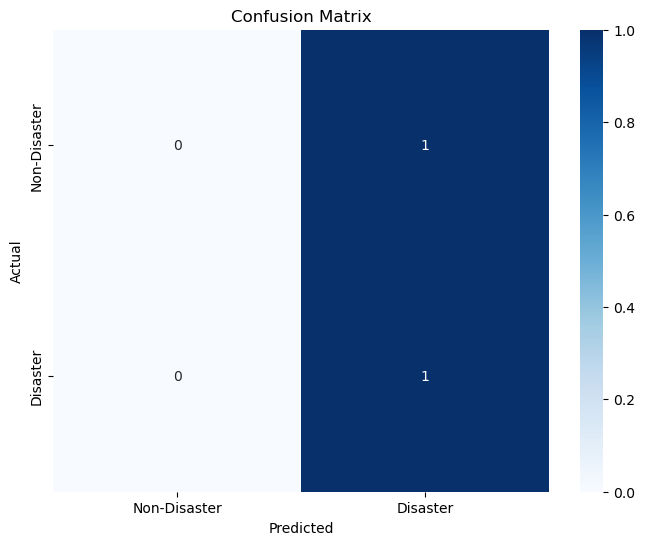

In [23]:

# Main execution
def main():
    print("Starting Tweet Classifier Project...")
    
    # Load data
    data = load_data()
    
    # Exploratory Data Analysis (Brief)
    print("\nClass Distribution:")
    print(data['target'].value_counts())
    
    # Preprocess data
    print("\nPreprocessing data...")
    processed_data = preprocess_data(data)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        processed_data['processed_text'], 
        processed_data['target'], 
        test_size=0.2, 
        random_state=42,
        stratify=processed_data['target']
    )
    
    # Extract features
    print("\nExtracting features...")
    X_train_features, X_test_features, vectorizer = extract_features(X_train, X_test)
    
    # Train models
    print("\nTraining models...")
    model_results, best_model = train_models(X_train_features, y_train)
    
    # Tune best model
    print("\nTuning hyperparameters...")
    tuned_model = tune_hyperparameters(X_train_features, y_train, best_model['name'])
    
    # Evaluate
    print("\nEvaluating model...")
    evaluation = evaluate_model(tuned_model, X_test_features, y_test)
    
    # Save model for deployment
    save_model(tuned_model, vectorizer)
    
    # Example predictions
    example_tweets = [
        "BREAKING: Earthquake of magnitude 6.8 strikes Japan, tsunami warning issued",
        "Just finished watching the new movie, it was amazing!",
        "Wildfire spreading rapidly near the city, residents urged to evacuate",
        "Looking forward to the weekend, planning to relax at home"
    ]
    
    print("\nExample Predictions:")
    for tweet in example_tweets:
        result = predict_tweet(tweet)
        print(f"Text: {tweet}")
        print(f"Prediction: {result['prediction']} (Probability: {result['probability']:.4f})")
        print("-" * 50)
    
    print("\nTweet Classifier Project completed successfully!")

if __name__ == "__main__":
    main()